#  prix des voitures d'occasion

Our client needs to predict second hand cars based on values such as age, km, vehicleType(4x4 or suv), fuelType, etc. 
He gave us a database found here : https://data.world/data-society/used-cars-data
According to those data, we will analyse which metric is more relevant for pricing, and then we will provide a set of machine learning models that predicts pricing. 

In [1]:
#load libraries
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn
from sklearn.model_selection import RandomizedSearchCV #automatic selection of best hyperparameters
from sklearn import ensemble

In [2]:
#to work with gpu
#from numba import njit
#sadly, scikit learn does not support cuda

In [308]:
#load dataset
df=pd.read_csv("autos.csv", encoding='iso-8859-15')

## Database refinement

Let's see if database is ready to use

In [309]:
df.head(5)

dateCrawled                            name  seller offerType  \
0  2016-03-24 11:52:17                      Golf_3_1.6  privat   Angebot   
1  2016-03-24 10:58:45            A5_Sportback_2.7_Tdi  privat   Angebot   
2  2016-03-14 12:52:21  Jeep_Grand_Cherokee_"Overland"  privat   Angebot   
3  2016-03-17 16:54:04              GOLF_4_1_4__3TÜRER  privat   Angebot   
4  2016-03-31 17:25:20  Skoda_Fabia_1.4_TDI_PD_Classic  privat   Angebot   

   price abtest vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480   test         NaN                1993    manuell        0   golf   
1  18300   test       coupe                2011    manuell      190    NaN   
2   9800   test         suv                2004  automatik      163  grand   
3   1500   test  kleinwagen                2001    manuell       75   golf   
4   3600   test  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  \
0     150000                    0   benzin  volkswagen               NaN   
1     125000                    5   diesel        audi                ja   
2     125000                    8   diesel        jeep               NaN   
3     150000                    6   benzin  volkswagen              nein   
4      90000                    7   diesel       skoda              nein   

           dateCreated  nrOfPictures  postalCode             lastSeen  
0  2016-03-24 00:00:00             0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00             0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00             0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00             0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00             0       60437  2016-04-06 10:17:21

In [310]:
df.describe() #shows satistics

price  yearOfRegistration        powerPS      kilometer  \
count  3.715280e+05       371528.000000  371528.000000  371528.000000   
mean   1.729514e+04         2004.577997     115.549477  125618.688228   
std    3.587954e+06           92.866598     192.139578   40112.337051   
min    0.000000e+00         1000.000000       0.000000    5000.000000   
25%    1.150000e+03         1999.000000      70.000000  125000.000000   
50%    2.950000e+03         2003.000000     105.000000  150000.000000   
75%    7.200000e+03         2008.000000     150.000000  150000.000000   
max    2.147484e+09         9999.000000   20000.000000  150000.000000   

       monthOfRegistration  nrOfPictures    postalCode  
count        371528.000000      371528.0  371528.00000  
mean              5.734445           0.0   50820.66764  
std               3.712412           0.0   25799.08247  
min               0.000000           0.0    1067.00000  
25%               3.000000           0.0   30459.00000  
50%               6.000000           0.0   49610.00000  
75%               9.000000           0.0   71546.00000  
max              12.000000           0.0   99998.00000

In [311]:
#setting aberations to limit
df.loc[df['yearOfRegistration'] > 2021, 'yearOfRegistration'] = 2021
df.loc[df['yearOfRegistration']<1900, 'yearOfRegistration'] = 1900

We consider that cars should not be older than fordism, and should not be produced in the future

dateCrawled  \
21467   2016-03-19 19:45:02   
347435  2016-03-30 15:50:46   
366861  2016-03-21 10:53:06   
364171  2016-04-04 21:25:21   
41980   2016-03-11 09:37:17   
45055   2016-04-02 00:06:21   
367041  2016-03-24 19:00:03   
333699  2016-03-12 03:36:18   
316200  2016-04-04 11:53:31   
78480   2016-03-10 20:43:12   

                                                     name  seller offerType  \
21467   Porsche_911_911R_1_of_20_ORIGINAL_R_nur_798KG!...  privat   Angebot   
347435         Schlachte_Golf_4_1.4_16_fast_alles_noch_da  privat   Angebot   
366861         Ferrari_FXX__unfallfrei__perfekter_Zustand  privat   Angebot   
364171                                        Ferrari_FXX  privat   Angebot   
41980                                       Maserati_MC12  privat   Angebot   
45055   Ferrari_LaFerrari_Deutsche_Auslieferung._A_Cel...  privat   Angebot   
367041                                      Maserati_MC12  privat   Angebot   
333699                                      Maserati_MC12  privat   Angebot   
316200                                        Ferrari_F40  privat   Angebot   
78480                                       Porsche_991_R  privat   Angebot   

          price   abtest vehicleType  yearOfRegistration  gearbox  powerPS  \
21467   9999999  control       coupe                1967  manuell      215   
347435  9999999     test         NaN                2000  manuell       75   
366861  3895000     test       coupe                2006      NaN      799   
364171  3890000     test       coupe                2006      NaN      799   
41980   2995000  control       coupe                2005      NaN      630   
45055   2795000  control       coupe                2016      NaN      963   
367041  1600000     test       coupe                2005      NaN      625   
333699  1600000     test       coupe                2005      NaN        0   
316200  1300000  control       coupe                1992      NaN        0   
78480   1250000     test       coupe                2016  manuell      500   

       model  kilometer  monthOfRegistration fuelType           brand  \
21467    911      50000                   10   benzin         porsche   
347435  golf     150000                    0   benzin      volkswagen   
366861   NaN       5000                    4   benzin  sonstige_autos   
364171   NaN       5000                    7      NaN  sonstige_autos   
41980    NaN       5000                    7   benzin  sonstige_autos   
45055    NaN       5000                    3      NaN  sonstige_autos   
367041   NaN      10000                    4   benzin  sonstige_autos   
333699   NaN      10000                    4      NaN  sonstige_autos   
316200   NaN      50000                   12      NaN  sonstige_autos   
78480    911       5000                    3   benzin         porsche   

       notRepairedDamage          dateCreated  nrOfPictures  postalCode  \
21467               nein  2016-03-19 00:00:00             0       70435   
347435                ja  2016-03-30 00:00:00             0       39576   
366861              nein  2016-03-21 00:00:00             0       60323   
364171              nein  2016-04-04 00:00:00             0       60313   
41980               nein  2016-03-11 00:00:00             0       74232   
45055               nein  2016-04-01 00:00:00             0       60435   
367041              nein  2016-03-24 00:00:00             0       70569   
333699              nein  2016-03-12 00:00:00             0       70569   
316200              nein  2016-04-04 00:00:00             0       60598   
78480               nein  2016-03-10 00:00:00             0       10719   

                   lastSeen  
21467   2016-04-01 10:45:30  
347435  2016-04-07 06:44:45  
366861  2016-03-22 10:36:39  
364171  2016-04-05 12:07:37  
41980   2016-04-06 21:47:44  
45055   2016-04-03 14:32:00  
367041  2016-03-24 19:41:13  
333699  2016-03-21 04:44:24  
316200  2016-04-05 11:34:11  
78480   2016-03

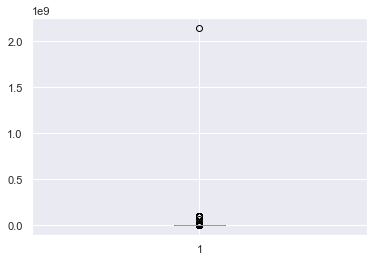

In [312]:
plt.boxplot(df.price)
df.sort_values(ascending=False, by="price")[50:60]

There is a buch of cars with fake price (too high). It seems that expensive's relevant car is Ferrari for 4M$. 
World's most expensive car is Bugatti La Voiture Noire : 16,7 millions d’euros TTC
Free cars are also errors

In [313]:
df=df[(df.price<4000000) & (df.price>0)]

In [315]:
#testing if values in string columns are correct
print("number of elements for each characteristics")
for e in ["seller", "offerType", "abtest", "vehicleType", "gearbox", "model", "fuelType", "brand", "notRepairedDamage"]:
    print(e)
    print(Counter(df[e]).items())

seller
dict_items([('privat', 360695), ('gewerblich', 3)])
offerType
dict_items([('Angebot', 360692), ('Gesuch', 6)])
abtest
dict_items([('test', 186852), ('control', 173846)])
vehicleType
dict_items([(nan, 34106), ('coupe', 18481), ('suv', 14502), ('kleinwagen', 78204), ('limousine', 93832), ('cabrio', 22559), ('bus', 29767), ('kombi', 66095), ('andere', 3152)])
gearbox
dict_items([('manuell', 267304), ('automatik', 75683), (nan, 17711)])
model
dict_items([('golf', 29076), (nan, 18284), ('grand', 604), ('fabia', 2060), ('3er', 19982), ('2_reihe', 4763), ('c_max', 690), ('3_reihe', 3435), ('passat', 9993), ('navara', 115), ('ka', 2612), ('polo', 12651), ('twingo', 4817), ('a_klasse', 4256), ('scirocco', 624), ('5er', 8342), ('meriva', 1036), ('arosa', 872), ('andere', 25684), ('c4', 445), ('civic', 1300), ('transporter', 5392), ('punto', 3241), ('e_klasse', 7406), ('clio', 3465), ('kadett', 329), ('kangoo', 942), ('one', 892), ('fortwo', 4297), ('1er', 3820), ('b_klasse', 936), ('signu

In [316]:
df[df.brand=="sonstige_autos"]

dateCrawled  \
60      2016-03-29 15:48:15   
318     2016-03-21 14:38:37   
376     2016-03-11 21:49:52   
446     2016-03-20 20:45:27   
678     2016-03-30 11:55:46   
...                     ...   
371203  2016-03-19 11:25:16   
371214  2016-03-29 19:57:29   
371216  2016-03-19 14:53:26   
371476  2016-03-15 13:52:34   
371523  2016-03-14 17:48:27   

                                                     name  seller offerType  \
60      TAUSCHE_BMW_E38_740i_g._SUV_/_GELÄNDEWAGEN_LES...  privat   Angebot   
318                       Tauache_90ccm_roller_gegen_auto  privat   Angebot   
376                                          Corvette_Z06  privat   Angebot   
446                                          Microcar_MC1  privat   Angebot   
678                                    Oldsmobile_Cutlass  privat   Angebot   
...                                                   ...     ...       ...   
371203                                Abarth_Grande_Punto  privat   Angebot   
371214      Oldsmobile_Dynamic_88_convertible_1960_Cabrio  privat   Angebot   
371216   Barkas__B1000__Scheunenfund__Lieferwagen__4_Takt  privat   Angebot   
371476                                  ALPINA_D3_Touring  privat   Angebot   
371523                         Suche_t4___vito_ab_6_sitze  privat   Angebot   

        price   abtest vehicleType  yearOfRegistration    gearbox  powerPS  \
60          1  control         suv                1994    manuell      286   
318       200  control         NaN                2009        NaN        0   
376     49500     test      cabrio                2013        NaN        0   
446      3950     test  kleinwagen                2004  automatik        5   
678     15000     test       coupe                1971        NaN        0   
...       ...      ...         ...                 ...        ...      ...   
371203   6000     test  kleinwagen                2008    manuell      155   
371214  30900  control      cabrio                1960  automatik      250   
371216   1750     test         NaN                1995        NaN        0   
371476   9400  control       kombi                2007    manuell      200   
371523   2200     test         NaN                2005        NaN        0   

       model  kilometer  monthOfRegistration fuelType           brand  \
60       NaN     150000                   11      NaN  sonstige_autos   
318      NaN      10000                    0      NaN  sonstige_autos   
376      NaN      10000                    6   benzin  sonstige_autos   
446      NaN      70000                    5   diesel  sonstige_autos   
678      NaN       5000                    4      NaN  sonstige_autos   
...      ...        ...                  ...      ...             ...   
371203   NaN     150000                    5   benzin  sonstige_autos   
371214   NaN     100000                    7   benzin  sonstige_autos   
371216   NaN     100000                   12      NaN  sonstige_autos   
371476   NaN     150000                    4   diesel  sonstige_autos   
371523   NaN      20000                    1      NaN  sonstige_autos   

       notRepairedDamage          dateCreated  nrOfPictures  postalCode  \
60                   NaN  2016-03-29 00:00:00             0       53721   
318                  NaN  2016-03-21 00:00:00             0        6493   
376                 nein  2016-03-11 00:00:00             0       79774   
446                 nein  2016-03-20 00:00:00             0       90562   
678                 nein  2016-03-30 00:00:00             0       51145   
...                  ...                  ...           ...         ...   
371203              nein  2016-03-19 00:00:00             0       63069   
371214              nein  2016-03-29 00:00:00             0       95444   
371216               NaN  2016-03-19 00:00:00             0        6188   
371476                ja  2016-03-15 00:00:00             0       91186   
371523               NaN  2016-03-14 00:00:00          

I suppose sonstige_autos implemented fake data for brand. We will replace brand from what we recognize in name column. 
We will also try to find true value when brand="andere" ("else")

In [317]:
#sonstige_autos with "Suche" in name should be considered as "gesuch" offerType
df['offerType'].mask((df.brand=="sonstige_autos") & (df.name.map(lambda x: x.lower()).str.contains("such")), 'Gesuch', inplace=True)

In [318]:
df['name'] = df['name'].astype(str)

In [385]:
#find brand in name and replace it with other brands found
brands=list(pd.unique(df.brand))+["aston martin", "aston_martin", "corvette", "triumph", "hummer", "maserati", "dodge","lotus","lincoln","cadillac","ferrari","lexus","pontiac","ssangyong","wartburg","isuzu","iveco"]
brands=[x for x in brands if str(x) != 'nan'] #remove nan from brands
for e in brands:
    df.loc[(df['name'].map(lambda x: x.lower()).str.contains(e)) & ((df.brand=="sonstige_autos") | (df.brand=="andere") | (df.brand=='nan')), "brand"] = e

In [386]:
#find model in name and replace it with other model found
models=list(pd.unique(df.model))
models=[x for x in models if str(x) != 'nan'] #remove nan from models
for e in models:
    df.loc[(df['name'].map(lambda x: x.lower()).str.contains(e)) & ((df.model=="andere") | (df.model=='nan')), "model"] = e

In [387]:
#set sonstige brands to NaN
df.loc[df.brand=="sonstige_autos", "brand"]=np.nan

## Database analyse

What can we primaly say about data?

In [321]:
df.head()

dateCrawled                            name  seller offerType  \
0  2016-03-24 11:52:17                      Golf_3_1.6  privat   Angebot   
1  2016-03-24 10:58:45            A5_Sportback_2.7_Tdi  privat   Angebot   
2  2016-03-14 12:52:21  Jeep_Grand_Cherokee_"Overland"  privat   Angebot   
3  2016-03-17 16:54:04              GOLF_4_1_4__3TÜRER  privat   Angebot   
4  2016-03-31 17:25:20  Skoda_Fabia_1.4_TDI_PD_Classic  privat   Angebot   

   price abtest vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480   test         NaN                1993    manuell        0   golf   
1  18300   test       coupe                2011    manuell      190    NaN   
2   9800   test         suv                2004  automatik      163  grand   
3   1500   test  kleinwagen                2001    manuell       75   golf   
4   3600   test  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  \
0     150000                    0   benzin  volkswagen               NaN   
1     125000                    5   diesel        audi                ja   
2     125000                    8   diesel        jeep               NaN   
3     150000                    6   benzin  volkswagen              nein   
4      90000                    7   diesel       skoda              nein   

           dateCreated  nrOfPictures  postalCode             lastSeen  
0  2016-03-24 00:00:00             0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00             0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00             0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00             0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00             0       60437  2016-04-06 10:17:21

In [322]:
df.corr()

price  yearOfRegistration   powerPS  kilometer  \
price                1.000000            0.119529  0.110361  -0.203624   
yearOfRegistration   0.119529            1.000000  0.052304  -0.220213   
powerPS              0.110361            0.052304  1.000000  -0.014203   
kilometer           -0.203624           -0.220213 -0.014203   1.000000   
monthOfRegistration  0.023298            0.044538  0.039372  -0.003813   
nrOfPictures              NaN                 NaN       NaN        NaN   
postalCode           0.036486            0.029524  0.026315  -0.028205   

                     monthOfRegistration  nrOfPictures  postalCode  
price                           0.023298           NaN    0.036486  
yearOfRegistration              0.044538           NaN    0.029524  
powerPS                         0.039372           NaN    0.026315  
kilometer                      -0.003813           NaN   -0.028205  
monthOfRegistration             1.000000           NaN    0.010813  
nrOfPictures                         NaN           NaN         NaN  
postalCode                      0.010813           NaN    1.000000

Text(0.5, 1.0, 'correlation matrix')

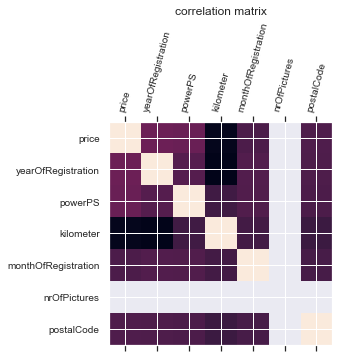

In [388]:
plt.matshow(df.corr())
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10, rotation=75)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10)
plt.title("correlation matrix")

mean price and number of elements for each ['gearbox', 'vehicleType', 'fuelType', 'brand']


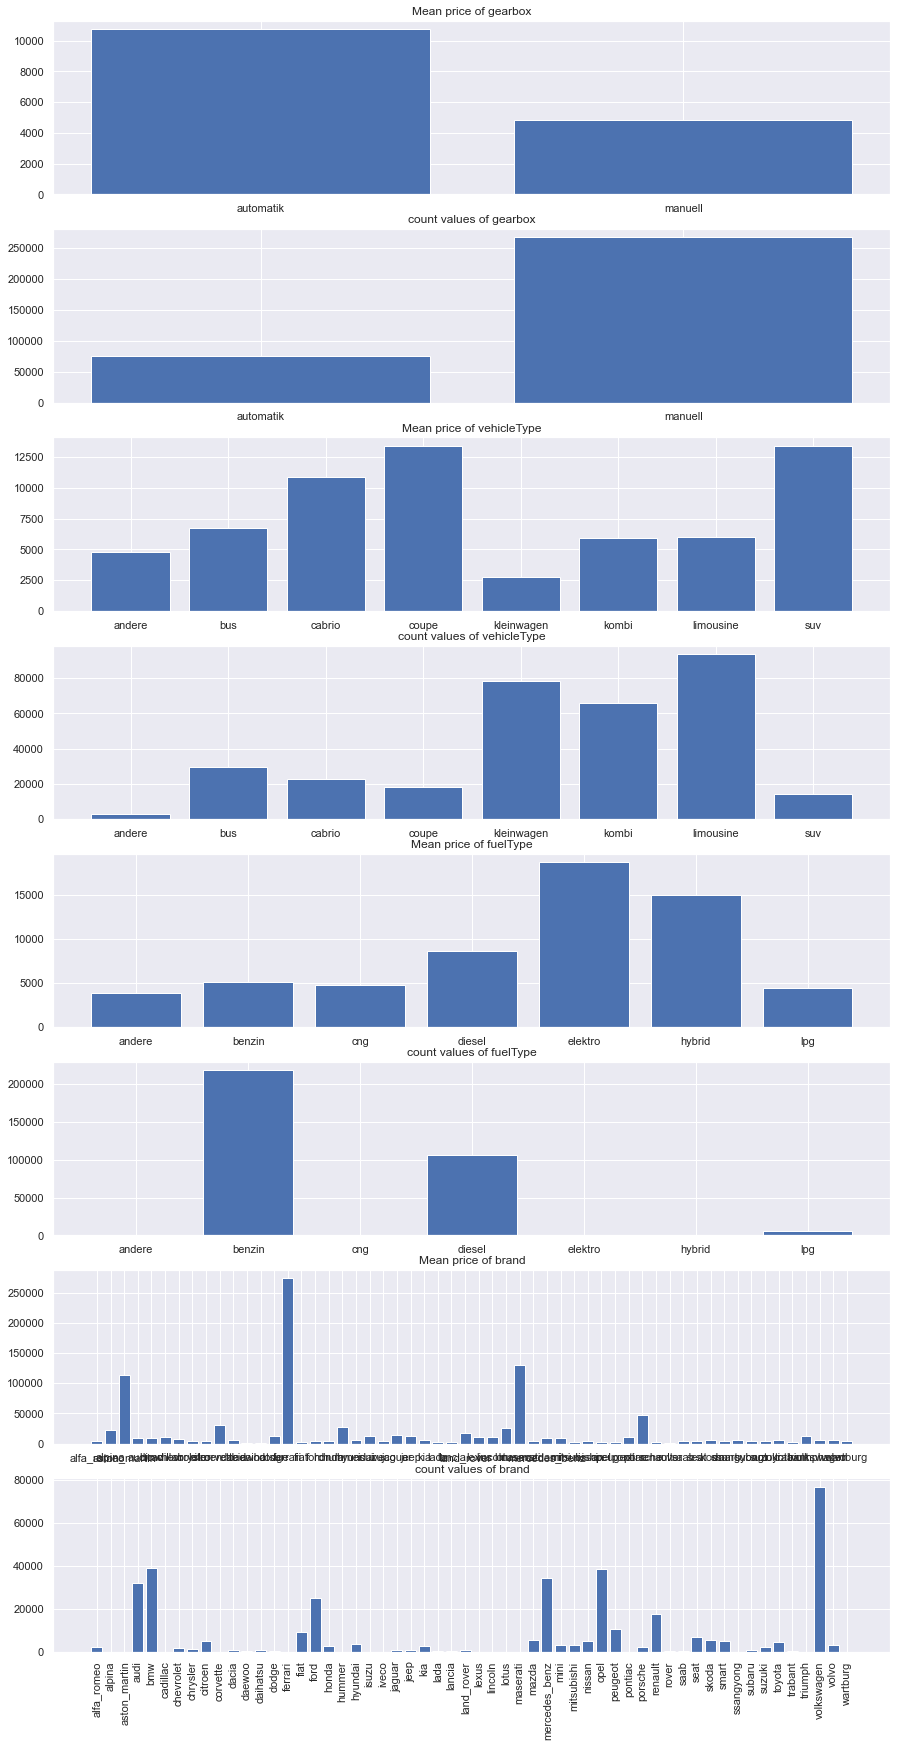

In [389]:
liste=[ "gearbox", "vehicleType", "fuelType", "brand"]
print("mean price and number of elements for each "+str(liste))
fig, ax = plt.subplots(2*len(liste), figsize=(15,30))
for i in range(len(liste)):
    group=df.groupby(liste[i], as_index=False).price
    ax[2*i].bar(x=liste[i], height="price", data=group.mean())
    ax[2*i+1].bar(x=liste[i], height="price", data=group.count())
    ax[2*i].set_title('Mean price of '+liste[i])
    ax[2*i+1].set_title('count values of '+liste[i])
    plt.xticks(rotation=90)
plt.show()

## Price prediction

### models evaluation function

In [328]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
#different function to evaluate diff between pred and expected price
def show_scores(model):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    scores = {
                #moyenne de la valeur absolue de l'erreur
                "Training MAE": mean_absolute_error(y_train, train_preds),
                "Valid MAE": mean_absolute_error(y_test, test_preds),
                #log attenuates the difference
                "Training RMSLE": np.sqrt(mean_squared_log_error(y_train, train_preds)),
                "Valid RMSLE": np.sqrt(mean_squared_log_error(y_test, test_preds)),
                #ratio difference squared of results to variance
                "Training R^2": r2_score(y_train, train_preds),
                "Valid R^2": r2_score(y_test, test_preds)}
    return scores

### Data formatting for prediction

In [329]:
#make a copy and drop useless columns
dfCopy=df.drop(columns=["dateCrawled", "dateCreated", "lastSeen", "name", "nrOfPictures", "abtest"])

In [330]:
#removing some nan
dfCopy.monthOfRegistration = dfCopy.monthOfRegistration.fillna(value=0)

Dummies create a column for each value of each column. it also removes nan

In [331]:
dfCopy=pd.get_dummies(data=dfCopy, columns=["vehicleType",'offerType', "seller", 'gearbox', "notRepairedDamage", "fuelType", "brand", "model"])

In [332]:
dfCopy.head()

price  yearOfRegistration  powerPS  kilometer  monthOfRegistration  \
0    480                1993        0     150000                    0   
1  18300                2011      190     125000                    5   
2   9800                2004      163     125000                    8   
3   1500                2001       75     150000                    6   
4   3600                2008       69      90000                    7   

   postalCode  vehicleType_andere  vehicleType_bus  vehicleType_cabrio  \
0       70435                   0                0                   0   
1       66954                   0                0                   0   
2       90480                   0                0                   0   
3       91074                   0                0                   0   
4       60437                   0                0                   0   

   vehicleType_coupe  ...  model_wrangler  model_x_reihe  model_x_trail  \
0                  0  ...               0              0              0   
1                  1  ...               0              0              0   
2                  0  ...               0              0              0   
3                  0  ...               0              0              0   
4                  0  ...               0              0              0   

   model_x_type  model_xc_reihe  model_yaris  model_yeti  model_ypsilon  \
0             0               0            0           0              0   
1             0               0            0           0              0   
2             0               0            0           0              0   
3             0               0            0           0              0   
4             0               0            0           0              0   

   model_z_reihe  model_zafira  
0              0             0  
1              0             0  
2              0             0  
3              0             0  
4              0             0  

[5 rows x 336 columns]

In [ ]:
#x valeurs connues pour effectuer la prediction
#y valeur attendue
X=dfCopy.drop("price", axis=1)
y=dfCopy.price

###  Principal component analysis (PCA).
dimension reduction

In [347]:
X.head()

yearOfRegistration  powerPS  kilometer  monthOfRegistration  postalCode  \
0                1993        0     150000                    0       70435   
1                2011      190     125000                    5       66954   
2                2004      163     125000                    8       90480   
3                2001       75     150000                    6       91074   
4                2008       69      90000                    7       60437   

   vehicleType_andere  vehicleType_bus  vehicleType_cabrio  vehicleType_coupe  \
0                   0                0                   0                  0   
1                   0                0                   0                  1   
2                   0                0                   0                  0   
3                   0                0                   0                  0   
4                   0                0                   0                  0   

   vehicleType_kleinwagen  ...  model_wrangler  model_x_reihe  model_x_trail  \
0                       0  ...               0              0              0   
1                       0  ...               0              0              0   
2                       0  ...               0              0              0   
3                       1  ...               0              0              0   
4                       1  ...               0              0              0   

   model_x_type  model_xc_reihe  model_yaris  model_yeti  model_ypsilon  \
0             0               0            0           0              0   
1             0               0            0           0              0   
2             0               0            0           0              0   
3             0               0            0           0              0   
4             0               0            0           0              0   

   model_z_reihe  model_zafira  
0              0             0  
1              0             0  
2              0             0  
3              0             0  
4              0             0  

[5 rows x 335 columns]

In [391]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(X)
X2 = pca.transform(X)

In [392]:
print(pca.explained_variance_ratio_)

[7.05512605e-01 2.94471230e-01 1.61320005e-05 2.52543949e-08
 6.01148293e-09 2.01690776e-10 1.41653919e-10 1.11811229e-10
 9.88527126e-11 9.57049135e-11]


We can see that 2 out of 4 new dimensions have no significance. Let's cut them.

In [337]:
X2[:, :2].shape

(360698, 2)

In [338]:
X3=X2[:, :2]

In [394]:
#Per-feature empirical mean, estimated from the training set.
meanPCA=pd.DataFrame(pca.mean_, X.columns.tolist(), columns=["mean"])
meanPCA=meanPCA.sort_values(by="mean", ascending=False)
meanPCA.head(15)

mean
kilometer               125663.477480
postalCode               50997.259899
yearOfRegistration        2003.436196
powerPS                    116.577647
monthOfRegistration          5.795740
seller_privat                0.999992
offerType_Angebot            0.999021
gearbox_manuell              0.741074
notRepairedDamage_nein       0.719949
fuelType_benzin              0.605063
fuelType_diesel              0.294393
vehicleType_limousine        0.260140
vehicleType_kleinwagen       0.216813
brand_volkswagen             0.213533
gearbox_automatik            0.209824

### finally let's try several models

In [339]:
#automatic splitting for training, validating and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

#### Random Forest

This model is shaped like a decision tree

In [340]:
from sklearn.ensemble import RandomForestRegressor
RandomForest = RandomForestRegressor(n_jobs=-1, #use all processors
                                    random_state=42) #always find same result
RandomForest.fit(X3, y)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [341]:
#Return the coefficient of determination of the prediction.
RandomForest.score(X3, y)

0.914540919672956

In [342]:
# hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10), #The number of trees in the forest
           "max_depth": [None, 3, 5, 10], #The maximum depth of the tree
           "min_samples_split": np.arange(2, 20, 2), #The minimum number of samples required to split an internal node
           "min_samples_leaf": np.arange(1, 20, 2), #min_samples_leaf
           "max_features": [0.5, 1, "sqrt", "auto"], #The number of features(caracteristics) to consider when looking for the best split
           "max_samples": [10000]} # the number of samples to draw from X to train each base estimator

# Instantiate RandomizedSearchCV model
rf_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                              param_distributions=rf_grid,
                              n_iter=5, #Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
                              cv=5, #number of folds (découpage)
                              verbose=True)  #affichage

# Fit the RandomizedSearchCV model
rf_model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   13.5s finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

We tried different types of hyperparameters, described in rf_grid. RandomizedSearchCV evaluates what is the optimal set of HP.

In [343]:
# Find the best model hyperparameters
rf_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 8,
 'min_samples_leaf': 17,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': 10}

In [344]:
# Evaluate the RandomizedSearch model
show_scores(rf_model)

{'Training MAE': 4551.794685934289,
 'Valid MAE': 4574.595875866571,
 'Training RMSLE': 1.3329891287507736,
 'Valid RMSLE': 1.3361847596717484,
 'Training R^2': 0.054303859242299635,
 'Valid R^2': 0.042743959276369536}

#### AdaBoostRegressor

Meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction. As such, subsequent regressors focus more on difficult cases.

In [345]:
from sklearn.ensemble import AdaBoostRegressor
regr = AdaBoostRegressor(random_state=42, n_estimators=100)
regr.fit(X3, y)
regr.score(X3, y)

KeyboardInterrupt: 

In [ ]:
# hyperparameters
ada_grid = {"n_estimators": np.arange(20, 60, 20), #The maximum number of estimators at which boosting is terminated. In case of perfect fit, the learning procedure is stopped early.
           "learning_rate": np.arange(0.3, 0.9, 0.3)} #Weight applied to each regressor at each boosting iteration. A higher learning rate increases the contribution of each regressor. There is a trade-off between the learning_rate and n_estimators parameters.

# Instantiate RandomizedSearchCV model
ada_model = RandomizedSearchCV(AdaBoostRegressor(random_state=42),
                              param_distributions=ada_grid,
                              n_iter=1, #Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
                              cv=3, #number of folds (découpage)
                              verbose=True)  #affichage

# Fit the RandomizedSearchCV model
ada_model.fit(X_train, y_train)

In [ ]:
ada_model.best_params_

In [ ]:
show_scores(ada_model)

#### Early stopping of Gradient Boosting
training stops when score stabilizes

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
est_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42)
est_model.fit(X_train, y_train)
show_scores(est_model)

## Best model selection

### correlation matrix

In [380]:
y_val_pred_rf=rf_model.predict(X_val)
covMatrix = np.cov(y_val_pred_rf, y_val,bias=True)
sn.heatmap(covMatrix, annot=True, fmt='g').set(title="Random Forest")

score mean square log of val set :1.3302939448344473


score mean square log of val set :4.90068435061568


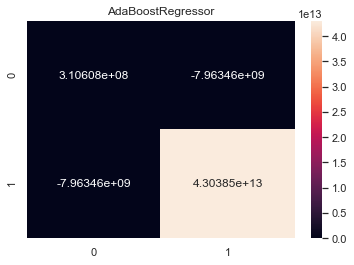

In [374]:
y_val_pred_ada=ada_model.predict(X_val)
covMatrix = np.cov(np.array([y_val, y_val_pred_ada]),bias=True)
sn.heatmap(covMatrix, annot=True, fmt='g').set(title="AdaBoostRegressor")

score mean square log of val set :2.2435638814936545


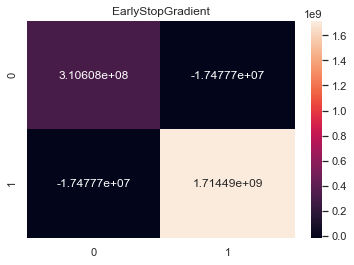

In [375]:
y_val_pred_est=est_model.predict(X_val)
covMatrix = np.cov(np.array([y_val, y_val_pred_est]),bias=True)
sn.heatmap(covMatrix, annot=True, fmt='g').set(title="EarlyStopGradient")

### Mean square log scores

In [381]:
print("score for randomForest :"+str(np.sqrt(mean_squared_log_error(y_val, y_val_pred_rf))))
print("score for adaBoostRegressor :"+str(np.sqrt(mean_squared_log_error(y_val, y_val_pred_ada))))
print("score for early stop gradient :"+str(np.sqrt(mean_squared_log_error(y_val, y_val_pred_est))))

score for randomForest :1.3302939448344473
score for adaBoostRegressor :4.90068435061568
score for early stop gradient :2.2435638814936545


## Conclusion

As expected, number of kilometes and age is significant for pricing, but surprisinly so is the place of the ad (postal code). 
At the begining, we had a dozen columns in our dataset. By detailling all dimensions into binary metrics columns (dummies), we obtained 330 columns. 
Finally, we could reduce the dataset to 2 main dimensions!
We've been training 3 different models based on that 2D dataframe. 
Among randomForest, adaBoostRegressor and early stop gradient, 
Random Forest is the best : the mean difference between expected price and predicted price is the lowest. 
Netherveless, Random Forest model had an advantage : we found its optimal parameters.